In [ ]:
!pip install benzinga

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 629.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.8 MB/s eta 0:00:00
  Created wheel for benzinga: filename=benzinga-1.21-py3-none-any.whl size=12212 sha256=63abc6628f1b1ec88cb588419f930cf41092692746592d856a68d631b4e02ac3
  Stored in directory: /root/.cache/pip/wheels/54/90/98/31c6b9e221854508d3ffa6ebf3d155bcd49c211d3f52341b84
Successfully built benzinga
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentry-sdk 2.17.0 requires urllib3>=1.26.11, but you have urllib3 1.25.10 which is incompatible.


In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4071    0  4071    0     0  10112      0 --:--:-- --:--:-- --:--:-- 10101
100  517k  100  517k    0     0   587k      0 --:--:-- --:--:-- --:--:--  587k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4059    0  4059    0     0  10283      0 --:--:-- --:--:-- --:--:-- 10275
100  392k  100  392k    0     0   401k      0 --:--:-- --:--:-- --:--:--  401k


In [ ]:
import pandas as pd
import talib as ta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from benzinga import financial_data

In [ ]:
# Setting up Benzinga API
api_key = "060fc707469a4680bec4894e5ce0ca7a"
fin = financial_data.Benzinga(api_key)
fin.bars

<bound method Benzinga.bars of <benzinga.financial_data.Benzinga object at 0x7ecf899bea40>>

# I. Fetching historical data and their technical indicators


In [ ]:
# Fetch historical data and store them in DataFrame
def fetch_data(symbol, date_from, date_to, interval):
    data = fin.bars(symbol, date_from, date_to, interval)
    print(data)
    candles = data[0]['candles']
    df = pd.DataFrame(candles)

    # Store as .CSV files
    filename = f"{date_from}_{symbol}_{interval}.csv"
    df.to_csv(filename, index=True)

    return df

In [ ]:
# Calculate indicators (MACD, RSI, Stochastics)
def calculate_indicators(df):
  df['macd'], df['macd_signal'], df['macd_hist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
  df['rsi'] = ta.RSI(df['close'], timeperiod=14)
  df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=14, slowk_period=3, slowd_period=3)
  return df

In [ ]:
# Prepare historical data to train model
def prepare_data(symbol, date_from, date_to, interval='1D'):
  df = fetch_data(symbol, date_from, date_to, interval)
  df = calculate_indicators(df)
  #return df

In [ ]:
def testing_one_stock():
  symbol = 'NVDA'
  date_from = '2024-01-01'
  date_to = '2024-10-05'
  interval = '1D'

  df = prepare_data(symbol, date_from, date_to, interval)
  #print(df.head(5))
  return df

In [ ]:
df_one_stock = testing_one_stock()

2024-11-01 03:45:44 [info     ] Status Code: 200 Endpoint: https://api.benzinga.com/api/v2/bars?token=060fc707469a4680bec4894e5ce0ca7a&symbols=NVDA&from=2024-01-01&to=2024-10-05&interval=1D
[]


IndexError: list index out of range

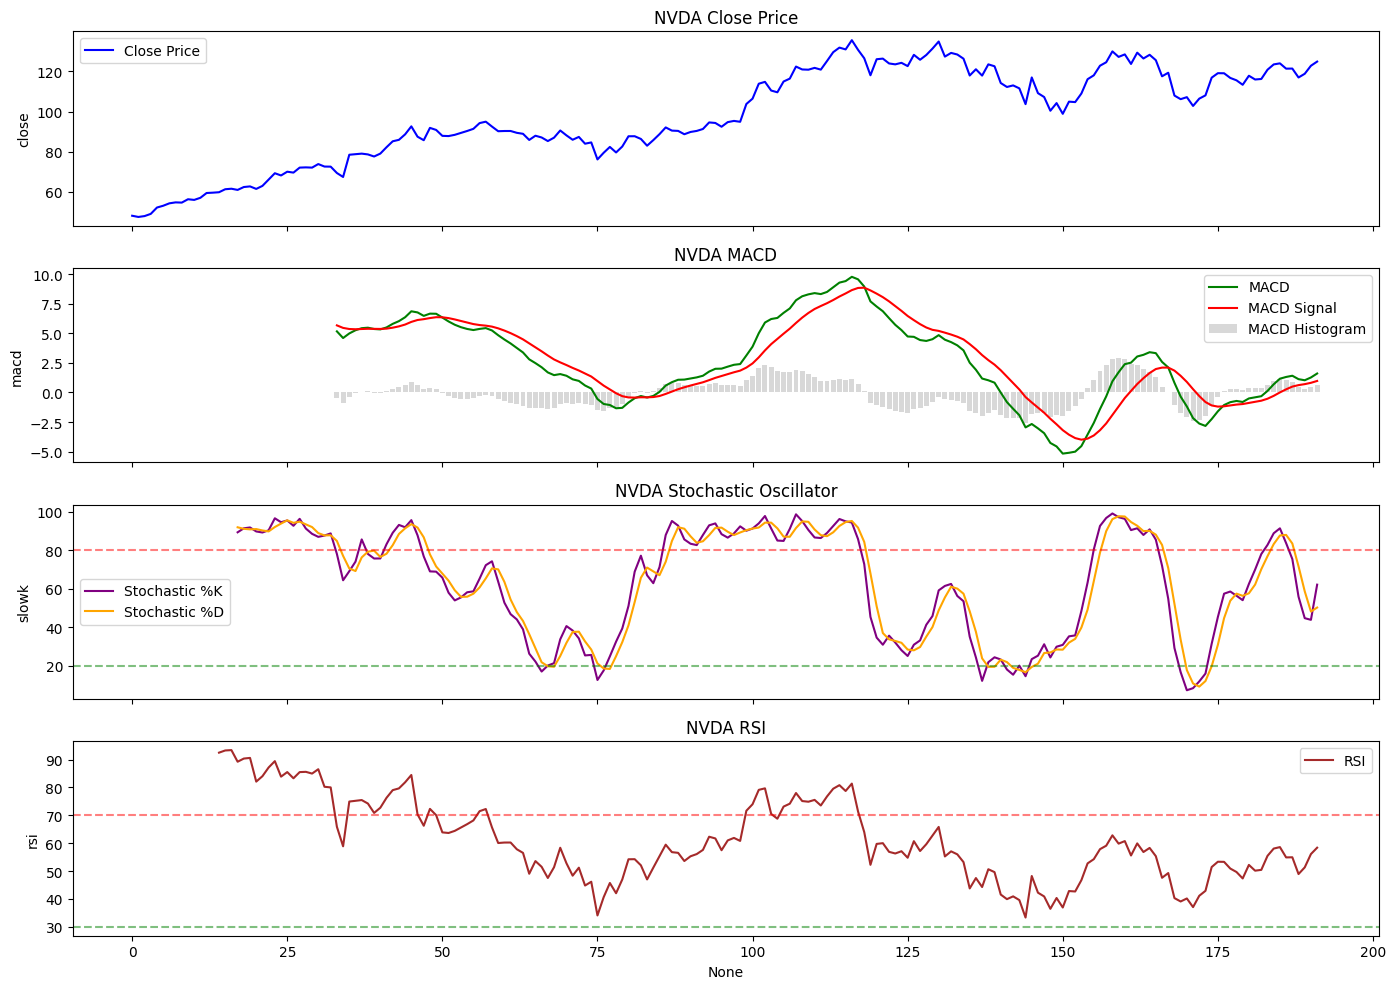

In [ ]:
def plot_indicators(df, symbol):
    # Create figure and set size
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)

    # Plot Close Price
    sns.lineplot(x=df.index, y=df['close'], ax=axes[0], color='blue', label='Close Price')
    axes[0].set_title(f'{symbol} Close Price')
    axes[0].legend()

    # Plot MACD with Signal Line and Histogram
    sns.lineplot(x=df.index, y=df['macd'], ax=axes[1], color='green', label='MACD')
    sns.lineplot(x=df.index, y=df['macd_signal'], ax=axes[1], color='red', label='MACD Signal')
    axes[1].bar(df.index, df['macd_hist'], color='gray', alpha=0.3, label='MACD Histogram')
    axes[1].set_title(f'{symbol} MACD')
    axes[1].legend()

    # Plot Stochastic Oscillator (%K and %D)
    sns.lineplot(x=df.index, y=df['slowk'], ax=axes[2], color='purple', label='Stochastic %K')
    sns.lineplot(x=df.index, y=df['slowd'], ax=axes[2], color='orange', label='Stochastic %D')
    axes[2].axhline(80, linestyle='--', color='red', alpha=0.5)  # Overbought line
    axes[2].axhline(20, linestyle='--', color='green', alpha=0.5)  # Oversold line
    axes[2].set_title(f'{symbol} Stochastic Oscillator')
    axes[2].legend()

    # Plot RSI
    sns.lineplot(x=df.index, y=df['rsi'], ax=axes[3], color='brown', label='RSI')
    axes[3].axhline(70, linestyle='--', color='red', alpha=0.5)  # Overbought line
    axes[3].axhline(30, linestyle='--', color='green', alpha=0.5)  # Oversold line
    axes[3].set_title(f'{symbol} RSI')
    axes[3].legend()

    # Final formatting
    plt.tight_layout()
    plt.show()

# Plot the indicators for NVDA
plot_indicators(df_one_stock, 'NVDA')

In [ ]:
def prepare_labels(df, future_period=2, threshold=0.05):
  # Future price to compare with predicted price
  df['future_price'] = df['close'].shift(-future_period)

  # Percent change between future price and predicted price
  df['price_change'] = (df['future_price'] - df['close']) / df['close']

  # Create the label
  df['signal'] = 0
  # Buy signal
  df.loc[df['price_change'] > threshold, 'signal'] = 1

  # Sell signal
  df.loc[(df['price_change'] < 0) & (df['signal'].shift(1) == 1), 'signal'] = -1

  # Short signal
  df.loc[df['price_change'] < -threshold, 'signal'] = -2

  # Cover signal
  df.loc[(df['price_change'] > 0) & (df['signal'].shift(1) == -2), 'signal'] = 2

  # Drop last rows with missing future price data
  df.dropna(inplace=True)
  return df

In [ ]:
# Prepare the feature set and labels for training
def prepare_features_and_labels(df):
  df = prepare_labels(df)
  features = ['macd', 'macd_hist', 'rsi', 'slowk', 'slowd']
  label = 'signal'
  X = df[features]
  y = df[label]
  return X, y

# II. Testing different models and hyper parameters

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import time
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

### 1) Testing different models

In [ ]:
# model training and evaluation
def model_evaluation(X, y, model_type):
  # Train test data split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=1234)

  # Training model
  if model_type == "rf":
    model = RandomForestClassifier(criterion='entropy', n_estimators=100)
    model.fit(X_train, y_train)

  elif model_type == "gdbt":
    model = GradientBoostingRegressor(max_depth = 4, n_estimators = 300)
    model.fit(X_train, y_train)

  elif model_type == "stack":
    estimators = [("DT", DecisionTreeRegressor(max_depth=8, min_samples_leaf=25)),
              ("LR", LinearRegression())]
    model = StackingRegressor(estimators = estimators, passthrough=False)
    model.fit(X_train, y_train)


  # Evaluate the model
  y_pred = model.predict(X_test)
  # accuracy = accuracy_score(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred, squared=False)
  r2 = r2_score(y_test, y_pred)

  print("RMSE", rmse)
  print("r2", r2)

  return model

In [ ]:
X_one_stock, y_one_stock = prepare_features_and_labels(df_one_stock)

In [ ]:
model_evaluation(X_one_stock, y_one_stock, 'stack')

RMSE 0.769008175681623
r2 -0.025997526435971308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


StackingRegressor(estimators=[('DT',
                               DecisionTreeRegressor(max_depth=8,
                                                     min_samples_leaf=25)),
                              ('LR', LinearRegression())])

In [ ]:
model_evaluation(X_one_stock, y_one_stock, 'rf')

RMSE 0.8779711460710616
r2 -0.3373493975903612


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RandomForestClassifier(criterion='entropy')

In [ ]:
model_evaluation(X_one_stock, y_one_stock, 'gdbt')

RMSE 0.7264166868345013
r2 0.08450490097262164


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


GradientBoostingRegressor(max_depth=4, n_estimators=300)

### 2) Grid Search for the best parameters

In [ ]:
def print_best_model(model_grid_search):
  rmse_DT = -1 * model_grid_search.best_score_
  print("RMSE for the best model is : {:.2f}".format(rmse_DT) )

  model_best_params = model_grid_search.best_estimator_
  print("Best parameters:", model_grid_search.best_params_)
  return model_best_params

a) Random Forest

In [ ]:
def optimize_rf(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=1234)

  param_grid = {'max_depth': [3,5,7,10],
      'n_estimators': [100, 200, 300, 400, 500],
      'max_features': [10, 20, 30 , 40],
      'min_samples_leaf': [1, 2, 4]}

  print('Running Grid Search...')
  model = RandomForestClassifier()

  dt_grid = GridSearchCV(model, param_grid, cv = 3, scoring='neg_root_mean_squared_error')

  model_grid_search = dt_grid.fit(X_train, y_train)
  print('Done')
  return model_grid_search

In [ ]:
model_grid_search_rf = optimize_rf(X_one_stock, y_one_stock)

Running Grid Search...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Done


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
print_best_model(model_grid_search_rf)

NameError: name 'print_best_model' is not defined

b) Gradient Boosting Regressor

In [ ]:
def optimize_gbt(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=1234)

  param_grid = {'max_depth': [4,6,8,10],
                'n_estimators': [100, 200, 300, 400, 500]}

  print('Running Grid Search...')
  model = GradientBoostingRegressor()

  dt_grid = GridSearchCV(model, param_grid, cv = 3, scoring='neg_root_mean_squared_error')

  model_grid_search = dt_grid.fit(X_train, y_train)

  print('Done')
  return model_grid_search

In [ ]:
model_grid_search_gbt = optimize_gbt(X_one_stock, y_one_stock)

Running Grid Search...
Done


In [ ]:
print_best_model(model_grid_search_gbt)

RMSE for the best model is : 0.98
Best parameters: {'max_depth': 4, 'n_estimators': 100}


GradientBoostingRegressor(max_depth=4)

# III. Training model using Random Forest Classifier

In [ ]:
def train_model(X, y):
  # Train the model
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

  model = RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=7, max_features=20)
  model.fit(X_train, y_train)
  # Evaluate the model
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)
  #proba_predictions = list(model.predict_proba(X_test)[:, 1])
  #fpr, tpr, thresholds = roc_curve(y_test, proba_predictions)
  #auc_result = auc(fpr, tpr)
  #print(auc_result)

  return model

In [ ]:
symbols = ['NVDA', 'SMCI', 'TSM', 'ALB', 'INTC', 'NFLX', 'JNJ', 'MTCH', 'AVGO', 'ORCL', 'AMD', 'TMUS', 'LRCX', 'PLTR', 'JD', 'VST', 'NET', 'FTV', 'SOFI']
date_from = '2024-01-01'
date_to = '2024-10-05'
interval = '1D'

for symbol in symbols:
  print(symbol)
  df= prepare_data(symbol, date_from, date_to, interval)
  X, y = prepare_features_and_labels(df)
  model = train_model(X, y)

NVDA
2024-10-22 17:03:19 [info     ] Status Code: 200 Endpoint: https://api.benzinga.com/api/v2/bars?token=060fc707469a4680bec4894e5ce0ca7a&symbols=NVDA&from=2024-01-01&to=2024-10-05&interval=1D
[{'symbol': 'NVDA', 'interval': 86400, 'candles': [{'time': '1704153600000', 'open': 49.244, 'high': 49.295, 'low': 47.595, 'close': 48.168, 'volume': '411254220', 'dateTime': '2024-01-02T15:00:00.000-05:00'}, {'time': '1704240000000', 'open': 47.485, 'high': 48.1841, 'low': 47.32, 'close': 47.569, 'volume': '320896170', 'dateTime': '2024-01-03T15:00:00.000-05:00'}, {'time': '1704326400000', 'open': 47.767, 'high': 48.5, 'low': 47.508, 'close': 47.998, 'volume': '306534890', 'dateTime': '2024-01-04T15:00:00.000-05:00'}, {'time': '1704412800000', 'open': 48.462, 'high': 49.547, 'low': 48.30601, 'close': 49.097, 'volume': '415039270', 'dateTime': '2024-01-05T15:00:00.000-05:00'}, {'time': '1704672000000', 'open': 49.512, 'high': 52.275, 'low': 49.479, 'close': 52.253, 'volume': '642509900', 'date

#III.I Training Model Using Gradient Boosting Regressor Model


# IV. Fetching real time data and execute trading

In [ ]:
# Function to fetch real-time data
def fetch_latest_data(symbol, interval='1M'):
  data = fin.bars(symbol, date_from='1d', date_to=None, interval=interval)
  candles = data[0]['candles']
  df = pd.DataFrame(candles)
  return df

In [ ]:
# Real-time trading with the trained model
def real_time_trading(symbol, model, poll_interval=60):
    model = model

    df = pd.DataFrame()

    while True:
        try:
            latest_data = fetch_latest_data(symbol, interval='1M')

            # Drop duplicates in case of overlapping data
            latest_data.drop_duplicates(subset='time', keep='last', inplace=True)

            # If DataFrame is empty, initialize with the latest data
            if df.empty:
                df = latest_data
            else:
              df = pd.concat([df, latest_data]).drop_duplicates(subset='time', keep='last')

            # Calculate technical indicators
            df = calculate_indicators(df)

            # Ensure indicators have suficient data to work on
            if len(df) >= 26:
                latest_row = df.iloc[-1].copy()

                # Prepare input for the model
                X_real_time = pd.DataFrame({
                    'macd': [latest_row['macd']],
                    'macd_hist': [latest_row['macd_hist']],
                    'rsi': [latest_row['rsi']],
                    'slowk': [latest_row['slowk']],
                    'slowd': [latest_row['slowd']]
                })

                # Make prediction with the model
                prediction = model.predict(X_real_time)[0]

                # Trade based on prediction
                if prediction == 1:
                    print(f"Buy Signal at price: {latest_row['close']} at {latest_row['time']}")
                elif prediction == -1:
                    print(f"Sell Signal at price: {latest_row['close']} at {latest_row['time']}")
                elif prediction == -2:
                    print(f"Short Signal at price: {latest_row['close']} at {latest_row['time']}")
                elif prediction == 2:
                    print(f"Cover Signal at price: {latest_row['close']} at {latest_row['time']}")
                else:
                    print(f"Hold at price: {latest_row['close']} at {latest_row['time']}")

        except Exception as e:
            print("Error: {e}")

        # Wait 60 seconds
        time.sleep(poll_interval)

# V.Testing

In [ ]:
if __name__ == "__main__":
    symbol = 'FTV'
    date_from = '2024-01-01'
    date_to = '2024-10-05'
    interval = '1D'

    # Fetch historical data
    df = fetch_data(symbol, date_from, date_to, interval)
    df = calculate_indicators(df)

    # Train the model
    X, y = prepare_features_and_labels(df)
    model = train_model(X, y)

    # Trading with real time data
    real_time_trading(symbol, model, poll_interval=60)

NameError: name 'fetch_data' is not defined

# Backtesting

**Risk Management Strategies**

- **Sharpe Ratio**: Measures the risk-adjusted returns [Measures volatility]
- **Maximum Drawdown**: Measure the largest peak-to-trough loss in portfolio [Assess risk tolerance]
- **Profit Factor**: Ratio of gross profits to gross losses [>1 = Profitable]
- **Win Rate**: Percentage of profitable trades out of the total trades executed [Consistency & Analyzed with Sharpe Ratio]
---



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Returns
df['returns'] = df['close'].pct_change()

# Cumulative Returns
df['cumulative_returns'] = (1 + df['returns']).cumprod()

# Calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    return (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252)

# Calculate Max Drawdown
def calculate_max_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    return drawdown.min()

# Calculate Profit Factor
def calculate_profit_factor(profit_trades, loss_trades):
    return abs(profit_trades.sum() / loss_trades.sum())

# Calculate Win Rate
def calculate_win_rate(profitable_trades, total_trades):
    return len(profitable_trades) / total_trades

# Assuming trades_df contains individual trade data with columns: 'profit_loss'
profitable_trades = trades_df[trades_df['profit_loss'] > 0]
loss_trades = trades_df[trades_df['profit_loss'] < 0]
total_trades = len(trades_df)

# Metric Calculation
sharpe_ratio = calculate_sharpe_ratio(df['returns'])
max_drawdown = calculate_max_drawdown(df['cumulative_returns'])
profit_factor = calculate_profit_factor(profitable_trades['profit_loss'], loss_trades['profit_loss'])
win_rate = calculate_win_rate(profitable_trades, total_trades)

# Display metrics
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Maximum Drawdown: {max_drawdown}")
print(f"Profit Factor: {profit_factor}")
print(f"Win Rate: {win_rate}")

# Plotting Cumulative Returns and Drawdowns
plt.figure(figsize=(14, 7))

# Cumulative Returns Plot
plt.subplot(2, 1, 1)
plt.plot(df['cumulative_returns'], label='Cumulative Returns')
plt.title("Cumulative Returns")
plt.legend()

# Drawdown Plot
plt.subplot(2, 1, 2)
df['drawdown'] = df['cumulative_returns'] / df['cumulative_returns'].cummax() - 1
plt.plot(df['drawdown'], color='red', label='Drawdown')
plt.title("Drawdown")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined